# This notebook used for multi-animal anlaysis after individual blocks are ready

In [1]:
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import scipy.stats as stats
import pandas as pd
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
import bokeh
import seaborn as sns
import os

In [2]:
def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df



In [3]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
#block_numbers = range(40,60)
#block_numbers = [12,34, 25, 70] # PV24
#block_numbers = [7,8,9,10,11,13] #pv 126
#block_numbers = [26] # example block for pv_62
block_numbers = range(1,14)
#block_numbers = [23,24,25,26,27,35,38,39,40,41] # pv 62
#bad_blocks = [42, 61, 62, 64, 65, 66] # True for PV_62
bad_blocks = [6]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_57'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b

instantiated block number 001 at Path: Z:\Nimrod\experiments\PV_57\2024_11_21\block_001, new OE version
Found the sample rate for block 001 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 001
got it!
instantiated block number 002 at Path: Z:\Nimrod\experiments\PV_57\2024_11_21\block_002, new OE version
Found the sample rate for block 002 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 002
got it!
instantiated block number 003 at Path: Z:\Nimrod\experiments\PV_57\2024_11_21\block_003, new OE version
Found the sample rate for block 003 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 003
got it!
instantiated block number 004 at Path: Z:\Nimrod\experi

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    

running parse_open_ephys_events...
block 001 has a parsed events file, reading...
getting eye brigtness values for block 001...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 002 has a parsed events file, reading...
getting eye brigtness values for block 002...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 003 has a parsed events file, reading...
getting eye brigtness values for block 003...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 004 has a parsed events file, reading...
getting eye brigtness values for block 004...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 005 has a parsed events file, reading...
getting eye brigtness values for block 005...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 007 has a parsed events file, reading...
getting eye brigtness values for block 007...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 008 has a parsed events file, reading...
getting eye brigtness values for block 008...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
getting eye brigtness values for block 009...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 010 has a parsed events file, reading...
getting eye brigtness values for block 010...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 011 has a parsed events file, reading...
getting eye brigtness values for block 011...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 012 has a parsed events file, reading...
getting eye brigtness values for block 012...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 013 has a parsed events file, reading...
getting eye brigtness values for block 013...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [5]:
for block in block_collection:
    print(block)
    # get major and minor columns:
    block.left_eye_data = block.get_maj_min_axes(block.left_eye_data)
    block.right_eye_data = block.get_maj_min_axes(block.right_eye_data)

PV_62, block 026, on 2023-04-27_12-21-41


C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2640: RuntimeWarning: All-NaN axis encountered
  df['major_ax'] = np.nanmax(df[['width', 'height']], axis=1)
C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2641: RuntimeWarning: All-NaN axis encountered
  df['minor_ax'] = np.nanmin(df[['width', 'height']], axis=1)


# pixel size calibration

In [5]:
# previous method
from ellipse import LsqEllipse
def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
    # import the dataframe and convert it to floats
    data = dlc_video_analysis_csv
    data = data.iloc[1:].apply(pd.to_numeric)

    # sort the pupil elements to dfs: x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])

    # get X coords
    pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]

    # flip the data around the midpoint of the x-axis (shooting the eye through a camera flips right and left)
    pupil_xs = 320 * 2 - pupil_xs_before_flip

    # get Y coords (no need to flip as opencv conventions already start with origin at top left of frame
    # and so, positive Y is maintained as up in a flipped image as we have)
    pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
    pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]

    # rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]

    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320*2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2,len(edge_elements),3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns,edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns,edge_xs.columns)))
    good_edge_points = edge_ps < uncertainty_thr
    
    # work row by row to figure out the ellipses
    ellipses = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm.tqdm(range(1, len(data) - 1)):
        # first, take all the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values, y_values]

        # now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]

        # if there are enough rows for a fit, make an ellipse
        if X.shape[0] > 5:
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x, center_y, width, height, phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])

        caudal_edge = [
            float(data['Caudal_edge'][row]),
            float(data['Caudal_edge.1'][row])
        ]
        rostral_edge = [
            float(data['Rostral_edge'][row]),
            float(data['Rostral_edge.1'][row])
        ]
        caudal_edge_ls.append(caudal_edge)
        rostral_edge_ls.append(rostral_edge)


    ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a * b * math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    ellipse_df['rostral_edge'] = rostral_edge_ls
    ellipse_df['caudal_edge'] = caudal_edge_ls

    print(f'\n ellipses calculation complete')
    
    ellipse_df[['caudal_edge_x', 'caudal_edge_y']] = pd.DataFrame(ellipse_df['caudal_edge'].tolist(), index=ellipse_df.index)
    ellipse_df[['rostral_edge_x', 'rostral_edge_y']] = pd.DataFrame(ellipse_df['rostral_edge'].tolist(), index=ellipse_df.index)
    
    return ellipse_df

def get_pixel_distance(df):
    distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                        (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
    
    mean_distance = np.nanmean(distances)
    std_distance = np.nanstd(distances)
    # Shapiro-Wilk Test
    shapiro_test = stats.shapiro(distances)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
    
    # Kolmogorov-Smirnov Test
    ks_test = stats.kstest(distances, 'norm', args=(mean_distance, std_distance))
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
    
    median_distance = np.median(distances)
    iqr_distance = stats.iqr(distances)
    print(f"Median Distance: {median_distance}")
    print(f"IQR: {iqr_distance}")
    print(f'mean = {mean_distance}')
    print(f'std = {std_distance}')
    return median_distance

R_pix_distance_dict = {}
L_pix_distance_dict = {}

for block in block_collection:
    print(f'working on {block}')
    pl = [i for i in os.listdir(block.r_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    R_csv  = pd.read_csv(block.r_e_path / pl, header=1)
    
    pl = [i for i in os.listdir(block.l_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    L_csv  = pd.read_csv(block.l_e_path / pl, header=1)
    R_ellipse_df = eye_tracking_analysis(R_csv,0.998)
    print('working on the right eye')
    R_pixel_distance = get_pixel_distance(R_ellipse_df)    
    L_ellipse_df = eye_tracking_analysis(L_csv,0.998)
    print('working on the left eye')
    L_pixel_distance = get_pixel_distance(L_ellipse_df)
    R_pix_distance_dict[block.block_num] = R_pixel_distance
    L_pix_distance_dict[block.block_num] = L_pixel_distance

working on PV_57, block 001, on pv_57_trial01_2024-11-21_15-32-31


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 54463/54463 [00:33<00:00, 1622.30it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.855273962020874, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.21231991658753735, p-value=0.0
Median Distance: 136.69511315721218
IQR: 132.41159030603092
mean = 111.92732177419146
std = 70.91214954717633


100%|██████████| 54490/54490 [00:33<00:00, 1641.97it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.5534809827804565, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.3119292623859309, p-value=0.0
Median Distance: 194.76325584272013
IQR: 15.282110575445472
mean = 176.65858762628514
std = 49.651961669272225
working on PV_57, block 002, on pv_57_trial02_2024-11-21_15-55-01


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 75418/75418 [00:46<00:00, 1620.68it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.8625227808952332, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.198272298314209, p-value=0.0
Median Distance: 136.81533359390116
IQR: 136.70175054821487
mean = 112.76707386354536
std = 71.912595868123


100%|██████████| 75592/75592 [00:46<00:00, 1635.75it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.5284698605537415, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.292970260312461, p-value=0.0
Median Distance: 200.7900757406636
IQR: 10.578415427506002
mean = 193.2667876097881
std = 30.86047250470791
working on PV_57, block 003, on pv_57_trial03_2024-11-21_16-20-30


100%|██████████| 5670/5670 [00:03<00:00, 1626.20it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.8470430970191956, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.212236445798612, p-value=1.359183964832191e-224
Median Distance: 98.40629487846982
IQR: 140.14391022075876
mean = 113.52379108592281
std = 72.84100441594084


100%|██████████| 30749/30749 [00:18<00:00, 1619.88it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.6439894437789917, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.276849762515491, p-value=0.0
Median Distance: 203.10250945850376
IQR: 17.690676790242946
mean = 188.67787372728668
std = 36.65562163303537
working on PV_57, block 004, on pv_57_trial04_2024-11-21_16-33-37


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 38077/38077 [00:23<00:00, 1608.89it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.8455737829208374, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.2012099570657938, p-value=0.0
Median Distance: 70.03235348755577
IQR: 139.56080822655866
mean = 109.35804698292183
std = 75.1259307896407


100%|██████████| 38175/38175 [00:23<00:00, 1624.88it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.796613335609436, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.21896663545048384, p-value=0.0
Median Distance: 145.4006290706258
IQR: 183.49256193195362
mean = 111.80314957717394
std = 83.85008985254015
working on PV_57, block 005, on pv_57_day2_01_2024-11-25_14-59-12


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 38540/38540 [00:21<00:00, 1819.21it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.828406035900116, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.20037550722400826, p-value=0.0
Median Distance: 52.35168064031726
IQR: 153.57566484296328
mean = 89.41298048364438
std = 76.45004811907705


100%|██████████| 38543/38543 [00:20<00:00, 1875.58it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.7605456113815308, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.2524764497058404, p-value=0.0
Median Distance: 172.43079197116506
IQR: 44.1326602191578
mean = 146.0198479657592
std = 68.22016541629809
working on PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 57766/57766 [00:35<00:00, 1613.77it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.8135883808135986, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.2005363561151643, p-value=0.0
Median Distance: 142.94124380826386
IQR: 147.58569086814094
mean = 117.72312484386616
std = 73.12684165042162


100%|██████████| 57764/57764 [00:31<00:00, 1825.60it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.54645174741745, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.29476565039221403, p-value=0.0
Median Distance: 195.80015272403125
IQR: 13.682775885663688
mean = 184.146221720437
std = 39.55252973392908
working on PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 61104/61104 [00:37<00:00, 1608.03it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.7541487216949463, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.2570532593921579, p-value=0.0
Median Distance: 190.7611590511292
IQR: 158.2494262698603
mean = 141.67619359261158
std = 77.05839835884476


100%|██████████| 61106/61106 [00:37<00:00, 1634.67it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.49609482288360596, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.25019625191681816, p-value=0.0
Median Distance: 199.77689855192477
IQR: 10.738968994015096
mean = 194.83679713007828
std = 23.340540339001908
working on PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 40168/40168 [00:24<00:00, 1664.48it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.7140859365463257, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.30836838911066516, p-value=0.0
Median Distance: 198.25156383835684
IQR: 146.33976560536055
mean = 157.48541325377667
std = 85.14395624002154


100%|██████████| 40172/40172 [00:24<00:00, 1633.58it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.5089144706726074, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.28697694637146975, p-value=0.0
Median Distance: 198.43240857571612
IQR: 13.241826006108624
mean = 188.546972524511
std = 38.46948739732731
working on PV_57, block 010, on PV_57_hunter__2024-12-01_15-37-36


100%|██████████| 15620/15620 [00:09<00:00, 1603.64it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
  1%|          | 162/15621 [00:00<00:09, 1603.67it/s]


 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.7051774263381958, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.3187804710283889, p-value=0.0
Median Distance: 200.68083366699898
IQR: 150.99077258886066
mean = 154.4268962673427
std = 79.35459339892645


100%|██████████| 15621/15621 [00:09<00:00, 1621.53it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.3737494945526123, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.35530244414225537, p-value=0.0
Median Distance: 181.70084505119647
IQR: 8.094186364831927
mean = 175.93713676658936
std = 31.981163509412216
working on PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 79158/79158 [00:49<00:00, 1608.20it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.6487603187561035, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.3685681027498464, p-value=0.0
Median Distance: 202.329586546811
IQR: 22.260380047074307
mean = 164.42870333159755
std = 74.06717112042415


100%|██████████| 79220/79220 [00:48<00:00, 1622.57it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.5128456354141235, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.37987379628209833, p-value=0.0
Median Distance: 185.73956792114956
IQR: 13.313826718175903
mean = 166.67072006485353
std = 56.264813133694894
working on PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 85788/85788 [00:53<00:00, 1616.59it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.5693046450614929, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.384400232541515, p-value=0.0
Median Distance: 206.4131947478577
IQR: 10.873614548381454
mean = 181.06379651746772
std = 64.51741002314938


100%|██████████| 85790/85790 [00:52<00:00, 1632.80it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.36439621448516846, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.33548169486256035, p-value=0.0
Median Distance: 189.31035997943692
IQR: 10.505788387335059
mean = 185.40899661829948
std = 27.579496750319226
working on PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 49834/49834 [00:30<00:00, 1650.79it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



 ellipses calculation complete
working on the right eye
Shapiro-Wilk Test: Statistic=0.8077845573425293, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.24924265826463726, p-value=0.0
Median Distance: 195.94318666140634
IQR: 163.3067775494153
mean = 140.64697858698463
std = 87.23839865183761


100%|██████████| 49843/49843 [00:30<00:00, 1624.63it/s]



 ellipses calculation complete
working on the left eye
Shapiro-Wilk Test: Statistic=0.35809028148651123, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.31108007850587055, p-value=0.0
Median Distance: 194.09842469080016
IQR: 10.100777951411771
mean = 190.36704457295394
std = 27.213939752809956


C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [6]:
# additional version for outlier removal:
from ellipse import LsqEllipse
import numpy as np
import pandas as pd
import math
import tqdm
from scipy import stats

def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame
    """
    # Import the dataframe and convert it to floats
    data = dlc_video_analysis_csv
    data = data.iloc[1:].apply(pd.to_numeric)

    # Sort the pupil elements to dfs: x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])

    # Get X coords and flip around the midpoint of the x-axis (for camera perspective)
    pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]
    pupil_xs = 320 * 2 - pupil_xs_before_flip

    # Get Y coords and P values (Y is not flipped)
    pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
    pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]

    # Masking invalid points based on P values
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]

    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320 * 2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2, len(edge_elements), 3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns, edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns, edge_xs.columns)))
    good_edge_points = edge_ps < uncertainty_thr

    # Work row by row to calculate ellipses
    ellipses = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm.tqdm(range(1, len(data) - 1)):
        # Concatenate X and Y values
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values, y_values]

        # Remove NaN values
        X = X[~np.isnan(X).any(axis=1)]

        # Check for enough points to fit an ellipse (increase the threshold for better fits)
        if X.shape[0] > 10:  # Increased minimum points for ellipse fitting
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            
            # Add a sanity check for extreme width/height ratios (outlier detection)
            if 0.2 < width / height < 5:  # Example sanity check
                ellipses.append([center_x, center_y, width, height, phi])
            else:
                ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])

        caudal_edge = [
            float(data['Caudal_edge'][row]),
            float(data['Caudal_edge.1'][row])
        ]
        rostral_edge = [
            float(data['Rostral_edge'][row]),
            float(data['Rostral_edge.1'][row])
        ]
        caudal_edge_ls.append(caudal_edge)
        rostral_edge_ls.append(rostral_edge)

    # Create dataframe for ellipse parameters
    ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    
    # Calculate ellipse size
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a * b * math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    ellipse_df['rostral_edge'] = rostral_edge_ls
    ellipse_df['caudal_edge'] = caudal_edge_ls

    print(f'\nEllipses calculation complete')
    
    ellipse_df[['caudal_edge_x', 'caudal_edge_y']] = pd.DataFrame(ellipse_df['caudal_edge'].tolist(), index=ellipse_df.index)
    ellipse_df[['rostral_edge_x', 'rostral_edge_y']] = pd.DataFrame(ellipse_df['rostral_edge'].tolist(), index=ellipse_df.index)
    
    return ellipse_df


def get_pixel_distance(df):
    """
    Calculate the pixel distance between rostral and caudal edges
    and return robust statistical measurements after filtering out outliers.
    """
    distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                        (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
    
    # Remove NaN values
    distances = distances[~np.isnan(distances)]
    
    # Median and IQR for robust filtering
    median_distance = np.median(distances)
    iqr_distance = stats.iqr(distances)
    
    # Filter out outliers (1.5 IQR from median)
    lower_bound = median_distance - 1.5 * iqr_distance
    upper_bound = median_distance + 1.5 * iqr_distance
    filtered_distances = distances[(distances >= lower_bound) & (distances <= upper_bound)]
    
    # Perform robust statistical tests on filtered data
    if len(filtered_distances) > 0:
        shapiro_test = stats.shapiro(filtered_distances)
        ks_test = stats.kstest(filtered_distances, 'norm', args=(np.mean(filtered_distances), np.std(filtered_distances)))

        print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
        print(f"Kolmogorov-Smirnov Test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
    else:
        print("No data left after outlier filtering")
    
    print(f"Median Distance: {median_distance}")
    print(f"IQR Distance: {iqr_distance}")
    
    return median_distance


R_pix_distance_dict = {}
L_pix_distance_dict = {}

for block in block_collection:
    print(f'Working on {block}')
    
    # Process right eye data
    pl = [i for i in os.listdir(block.r_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    R_csv  = pd.read_csv(block.r_e_path / pl, header=1)
    R_ellipse_df = eye_tracking_analysis(R_csv, 0.998)
    print('Working on the right eye')
    R_pixel_distance = get_pixel_distance(R_ellipse_df)    
    
    # Process left eye data
    pl = [i for i in os.listdir(block.l_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    L_csv  = pd.read_csv(block.l_e_path / pl, header=1)
    L_ellipse_df = eye_tracking_analysis(L_csv, 0.998)
    print('Working on the left eye')
    L_pixel_distance = get_pixel_distance(L_ellipse_df)
    
    R_pix_distance_dict[block.block_num] = R_pixel_distance
    L_pix_distance_dict[block.block_num] = L_pixel_distance


Working on PV_57, block 001, on pv_57_trial01_2024-11-21_15-32-31


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 54463/54463 [00:09<00:00, 5654.46it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.8528462052345276, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.21364048035892913, p-value=0.0
Median Distance: 136.69511315721218
IQR Distance: 132.41159030603092


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 54490/54490 [00:09<00:00, 5587.63it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9753941893577576, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.05886699868046147, p-value=2.958849708139123e-130
Median Distance: 194.76325584272013
IQR Distance: 15.282110575445472
Working on PV_57, block 002, on pv_57_trial02_2024-11-21_15-55-01


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 75418/75418 [00:13<00:00, 5653.09it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.8584383726119995, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.20126019533424244, p-value=0.0
Median Distance: 136.81533359390116
IQR Distance: 136.70175054821487


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 75592/75592 [00:13<00:00, 5635.77it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye


  0%|          | 0/5670 [00:00<?, ?it/s]

Shapiro-Wilk Test: Statistic=0.9954897165298462, p-value=6.30326189769039e-38
Kolmogorov-Smirnov Test: Statistic=0.01083735438004052, p-value=6.242471452426085e-07
Median Distance: 200.7900757406636
IQR Distance: 10.578415427506002
Working on PV_57, block 003, on pv_57_trial03_2024-11-21_16-20-30


100%|██████████| 5670/5670 [00:01<00:00, 5669.37it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.845882773399353, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.2125064880937304, p-value=3.946567637830955e-225
Median Distance: 98.40629487846982
IQR Distance: 140.14391022075876


100%|██████████| 30749/30749 [00:05<00:00, 5601.31it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9592299461364746, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.09012197233611824, p-value=9.457849713256143e-172
Median Distance: 203.10250945850376
IQR Distance: 17.690676790242946
Working on PV_57, block 004, on pv_57_trial04_2024-11-21_16-33-37


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 38077/38077 [00:06<00:00, 5675.88it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.8423163294792175, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.20302129766989996, p-value=0.0
Median Distance: 70.03235348755577
IQR Distance: 139.56080822655866


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 38175/38175 [00:06<00:00, 5706.44it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.7922369241714478, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.22022658628792302, p-value=0.0
Median Distance: 145.4006290706258
IQR Distance: 183.49256193195362
Working on PV_57, block 005, on pv_57_day2_01_2024-11-25_14-59-12


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 38540/38540 [00:06<00:00, 5671.82it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.8279396295547485, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.20046096950881886, p-value=0.0
Median Distance: 52.35168064031726
IQR Distance: 153.57566484296328


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 38543/38543 [00:06<00:00, 5627.77it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9878045916557312, p-value=1.3032075718220799e-43
Kolmogorov-Smirnov Test: Statistic=0.040112126612090626, p-value=1.797670074286628e-42
Median Distance: 172.43079197116506
IQR Distance: 44.1326602191578
Working on PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 57766/57766 [00:10<00:00, 5621.84it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.8133189678192139, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.20060956329629742, p-value=0.0
Median Distance: 142.94124380826386
IQR Distance: 147.58569086814094


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 57764/57764 [00:10<00:00, 5670.36it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9959203004837036, p-value=2.315822171834994e-32
Kolmogorov-Smirnov Test: Statistic=0.022927529058195784, p-value=2.422256355818443e-21
Median Distance: 195.80015272403125
IQR Distance: 13.682775885663688
Working on PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 61104/61104 [00:10<00:00, 5612.37it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.7536502480506897, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.2573098594723869, p-value=0.0
Median Distance: 190.7611590511292
IQR Distance: 158.2494262698603


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 61106/61106 [00:10<00:00, 5671.49it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9917205572128296, p-value=1.401298464324817e-45
Kolmogorov-Smirnov Test: Statistic=0.02891095392091314, p-value=1.8255242827084406e-39
Median Distance: 199.77689855192477
IQR Distance: 10.738968994015096
Working on PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 40168/40168 [00:07<00:00, 5635.03it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.7209898233413696, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.33334189637151906, p-value=0.0
Median Distance: 198.25156383835684
IQR Distance: 146.33976560536055


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 40172/40172 [00:07<00:00, 5599.65it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9954085946083069, p-value=5.790213585935774e-30
Kolmogorov-Smirnov Test: Statistic=0.020495116368134503, p-value=2.463448185493829e-12
Median Distance: 198.43240857571612
IQR Distance: 13.241826006108624
Working on PV_57, block 010, on PV_57_hunter__2024-12-01_15-37-36


100%|██████████| 15620/15620 [00:02<00:00, 5558.71it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.7046480178833008, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.3188965577466421, p-value=0.0
Median Distance: 200.68083366699898
IQR Distance: 150.99077258886066


100%|██████████| 15621/15621 [00:02<00:00, 5701.42it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9930323362350464, p-value=2.3857885204767725e-25
Kolmogorov-Smirnov Test: Statistic=0.019956996370657176, p-value=3.039720438027228e-05
Median Distance: 181.70084505119647
IQR Distance: 8.094186364831927
Working on PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 79158/79158 [00:14<00:00, 5611.42it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.9851911664009094, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.050660047272614694, p-value=1.4476784936944863e-134
Median Distance: 202.329586546811
IQR Distance: 22.260380047074307


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 79220/79220 [00:13<00:00, 5667.93it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9931684732437134, p-value=1.401298464324817e-45
Kolmogorov-Smirnov Test: Statistic=0.03582907555032655, p-value=4.6823739943528615e-76
Median Distance: 185.73956792114956
IQR Distance: 13.313826718175903
Working on PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 85788/85788 [00:15<00:00, 5642.87it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.9934946894645691, p-value=9.80908925027372e-45
Kolmogorov-Smirnov Test: Statistic=0.02482226017998257, p-value=7.444308431995752e-37
Median Distance: 206.4131947478577
IQR Distance: 10.873614548381454


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 85790/85790 [00:15<00:00, 5606.20it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Ellipses calculation complete
Working on the left eye


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 49834/49834 [00:08<00:00, 5682.16it/s]
C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test: Statistic=0.9847126603126526, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.05243549843603185, p-value=3.6225520140905395e-194
Median Distance: 189.31035997943692
IQR Distance: 10.505788387335059
Working on PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43

Ellipses calculation complete
Working on the right eye
Shapiro-Wilk Test: Statistic=0.7982146739959717, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.2557842872852181, p-value=0.0
Median Distance: 195.94318666140634
IQR Distance: 163.3067775494153


c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 49843/49843 [00:08<00:00, 5562.98it/s]


Ellipses calculation complete
Working on the left eye
Shapiro-Wilk Test: Statistic=0.9892377853393555, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.03355621258908392, p-value=1.156845619444432e-46
Median Distance: 194.09842469080016
IQR Distance: 10.100777951411771



C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [51]:
# Verify the values make sense:
known_dist = 7.8
for block in block_dict.keys():
    print(block)
    print(f'left calibration value: {known_dist / L_pix_distance_dict[block]}')
    print(f'right calibration value: {known_dist / R_pix_distance_dict[block]}')

exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_025\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_04_27\block_027\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_04_30\block_035\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_05_01\block_039\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_05_01\block_040\analysis\LR_pix_size.csv
exported to Z:\Nimrod\experiments\PV_62\2023_05_01\block_041\analysis\LR_pix_size.csv


In [ ]:
# This is the export step, when happy with the values
for block in block_collection:
    block.L_pix_size = known_dist / L_pix_distance_dict[block.block_num]
    block.R_pix_size = known_dist / R_pix_distance_dict[block.block_num]
    internal_df = pd.DataFrame(columns=['L_pix_size', 'R_pix_size'])
    internal_df.at[0, 'L_pix_size'] = block.L_pix_size
    internal_df.at[0, 'R_pix_size'] = block.R_pix_size
    internal_df.to_csv(block.analysis_path / 'LR_pix_size.csv', index=False)
    print(f'exported to {block.analysis_path / "LR_pix_size.csv"}')

# Manual annotation, if required:

In [6]:
real_distance = 7.8  # mm

for block in block_collection:
    block.calibrate_pixel_size(10)
    print(f'the previous calibration pixel sizes were: ')
    print(f'left = {block.L_pix_size} right = {block.R_pix_size}')
    print(f'the new calibration pixel sizes are: ')
    print(f'left = {real_distance / L_pix_distance_dict[block.block_num]} right = {real_distance / R_pix_distance_dict[block.block_num]}')
   
    block.L_pix_size = real_distance / L_pix_distance_dict[block.block_num]
    block.R_pix_size = real_distance / R_pix_distance_dict[block.block_num]

In [13]:
left_calibration_values = [b.L_pix_size for b in block_collection]
right_calibration_values = [b.R_pix_size for b in block_collection]

In [14]:
def get_round_eye_frame(block,eye):
    if eye == 'left':
        df = block.left_eye_data
    elif eye == 'right':
        df = block.right_eye_data
    else:
        print('Eye not recognized, try left/right')
    s = df.major_ax / df.minor_ax
    anchor_ind = np.argmin(np.abs(s - 1))  # find the index of the value closest to 1
    roundest_frame_num = df['eye_frame'].iloc[anchor_ind]
    frame = block.get_rotated_frame(roundest_frame_num, eye)
    return frame

def manual_distance_annotation(block, overwrite, known_dist):
    # let's start with left frame:
    lframe = get_round_eye_frame(block,'left')
    rframe = get_round_eye_frame(block,'right')

    Rroi = cv2.selectROI(
        "select the area of the known measurement through the diagonal of the ROI", rframe)
    Lroi = cv2.selectROI(
        "select the area of the known measurement through the diagonal of the ROI", lframe)


    R_dist = np.sqrt(Rroi[2] ** 2 + Rroi[3] ** 2)
    L_dist = np.sqrt(Lroi[2] ** 2 + Lroi[3] ** 2)

    manual_L_pix_size = known_dist / L_dist
    manual_R_pix_size = known_dist / R_dist

    cv2.destroyAllWindows()

    internal_df = pd.DataFrame(columns=['L_pix_size', 'R_pix_size'])
    internal_df.at[0, 'L_pix_size'] = block.L_pix_size
    internal_df.at[0, 'R_pix_size'] = block.R_pix_size
    if overwrite:
        # save these values to a dataframe for re-initializing the block:
        block.L_pix_size = manual_L_pix_size
        block.R_pix_size = manual_R_pix_size
        internal_df.to_csv(block.analysis_path / 'LR_pix_size.csv', index=False)
        print(f'exported to {block.analysis_path / "LR_pix_size.csv"}')
        
    print(f'Left side: {manual_L_pix_size}')
    print(f'right side: {manual_R_pix_size}')
    return internal_df

007
left eye calibration value: 0.027983991020158118, right eye calibration value0.02856618220340118
exported to Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\analysis\LR_pix_size.csv
Left side: 0.03878245879276301
right side: 0.04019764196607088
  L_pix_size R_pix_size
0  0.0289064  0.0293695
008
left eye calibration value: 0.027983991020158118, right eye calibration value0.02856618220340118
exported to Z:\Nimrod\experiments\PV_126\2024_07_18\block_008\analysis\LR_pix_size.csv
Left side: 0.03803746822934531
right side: 0.039762810276451545
  L_pix_size R_pix_size
0  0.0284757  0.0260145
009
left eye calibration value: 0.027983991020158118, right eye calibration value0.02856618220340118
exported to Z:\Nimrod\experiments\PV_126\2024_07_18\block_009\analysis\LR_pix_size.csv
Left side: 0.04147469607127374
right side: 0.03747229404867428
  L_pix_size R_pix_size
0  0.0338174  0.0313665
010
left eye calibration value: 0.027983991020158118, right eye calibration value0.02856618220340118
e

In [ ]:
for b in block_collection:
    print(b.block_num)
    print(f'left eye calibration value: {block.L_pix_size}, right eye calibration value{block.R_pix_size}')
    calib_df = manual_distance_annotation(b,overwrite=False,known_dist=7.8)
    print(calib_df)
    

# after pixel size calibration:

In [7]:
for block in block_collection:
    print(block.block_num)
    load_eye_data_2d_w_rotation_matrix(block) 

001
002
003
004
005
007
008
009
010
011
012
013


In [8]:
for block in block_collection:
    block.right_eye_data['calibrated_pupil_diameter'] = (block.right_eye_data['major_ax'] * 2 * np.pi) * block.R_pix_size
    block.left_eye_data['calibrated_pupil_diameter'] = (block.left_eye_data['major_ax'] * 2 * np.pi) * block.L_pix_size
    

PV_57, block 001, on pv_57_trial01_2024-11-21_15-32-31 13.484842708831886 6.716284115654849
PV_57, block 002, on pv_57_trial02_2024-11-21_15-55-01 15.690731535894757 6.162957713284151
PV_57, block 003, on pv_57_trial03_2024-11-21_16-20-30 12.061783814097264 9.857989799652078
PV_57, block 004, on pv_57_trial04_2024-11-21_16-33-37 18.294375348324028 9.875489028295188
PV_57, block 005, on pv_57_day2_01_2024-11-25_14-59-12 13.44117182101031 19.02085930885006
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31 15.130864754189187 6.177820686707719
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18 17.025746115867033 4.6137859275611355
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35 17.420320517270113 3.8420792425049335
PV_57, block 010, on PV_57_hunter__2024-12-01_15-37-36 31.332670400731132 5.732412221262867
PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28 27.6802415471544 4.54265624193046
PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39 24.768799655628776 4.1969

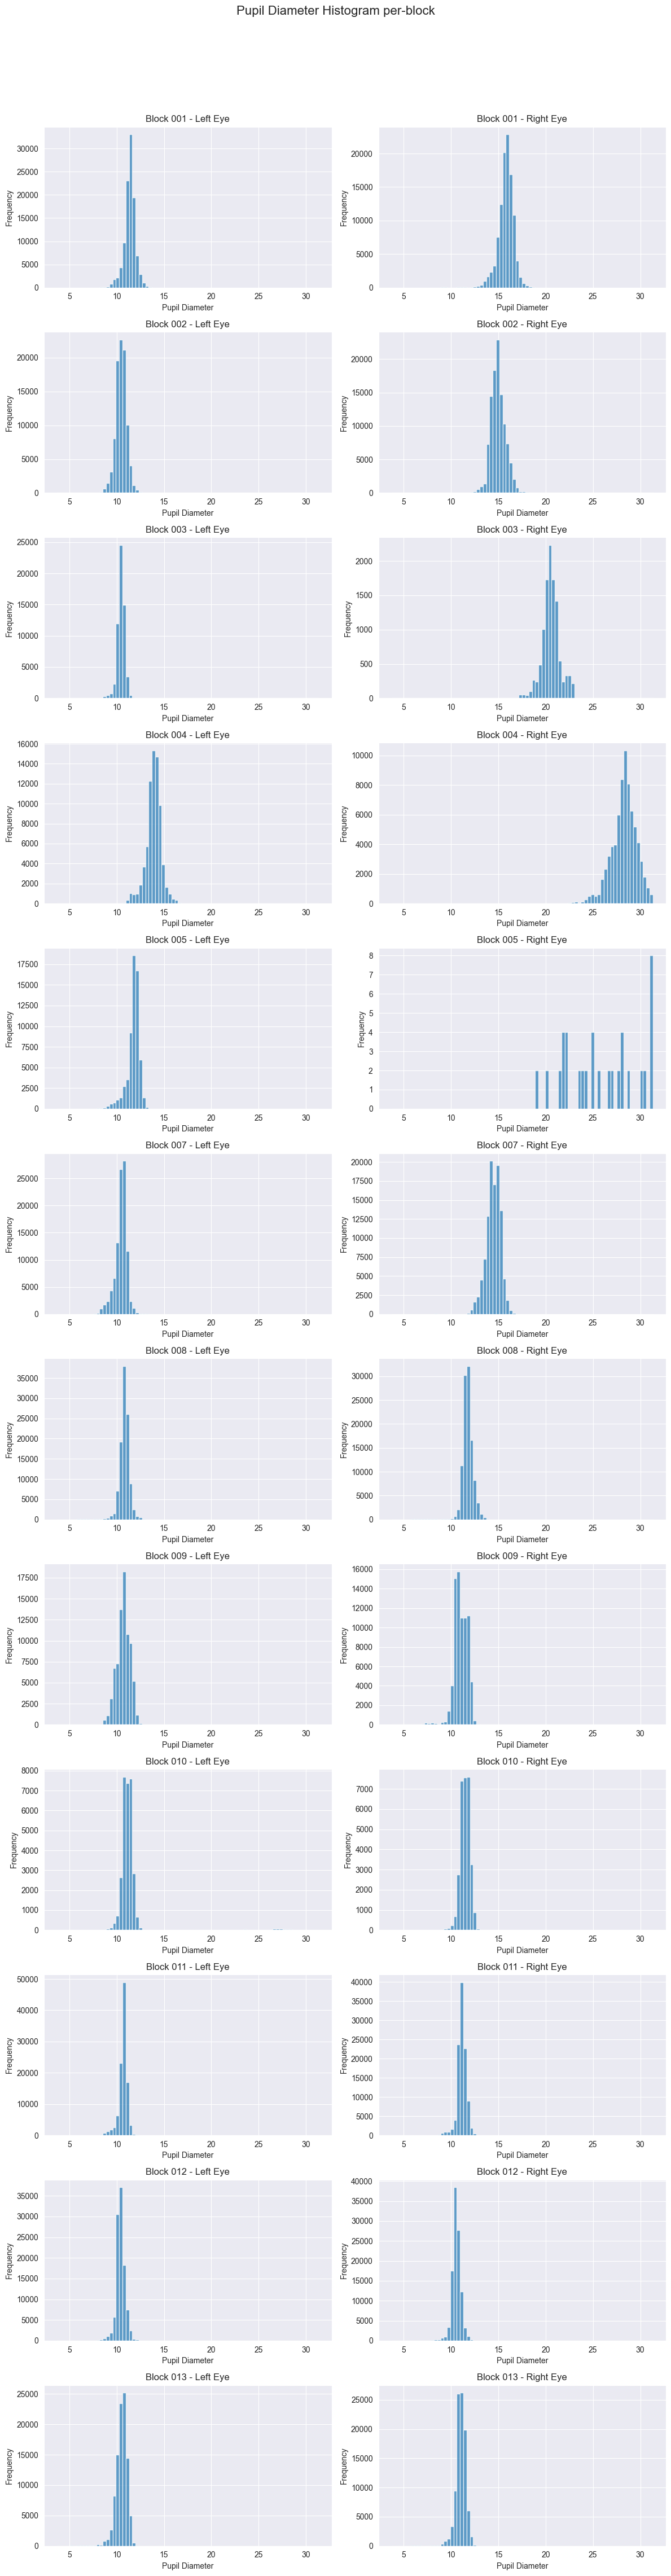

In [9]:
# Pupil diameter sanity check
blocks = block_collection
bins = 80
# Determine the overall min and max pupil diameter
extreme_pupil_diameters = []
for block in blocks:
    block_max = np.max(block.left_eye_data['calibrated_pupil_diameter'].dropna())
    block_min = np.min(block.right_eye_data['calibrated_pupil_diameter'].dropna())
    print(block, block_max, block_min)
    extreme_pupil_diameters.append(block_max)
    extreme_pupil_diameters.append(block_min)
    
min_diameter = np.min(extreme_pupil_diameters)
max_diameter = np.max(extreme_pupil_diameters)

# Create the figure and subplots
fig, axs = plt.subplots(len(blocks), 2, figsize=(12, 4 * len(blocks)), dpi=100)
fig.suptitle('Pupil Diameter Histogram per-block', fontsize=16)

# Iterate through blocks and plot histograms
for i, block in enumerate(blocks):
    # Left eye histogram
    axs[i, 0].hist(block.left_eye_data['calibrated_pupil_diameter'].dropna(), bins=bins, range=(min_diameter, max_diameter), alpha=0.7)
    axs[i, 0].set_title(f'Block {block.block_num} - Left Eye')
    axs[i, 0].set_xlabel('Pupil Diameter')
    axs[i, 0].set_ylabel('Frequency')

    # Right eye histogram
    axs[i, 1].hist(block.right_eye_data['calibrated_pupil_diameter'].dropna(), bins=bins, range=(min_diameter, max_diameter), alpha=0.7)
    axs[i, 1].set_title(f'Block {block.block_num} - Right Eye')
    axs[i, 1].set_xlabel('Pupil Diameter')
    axs[i, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Saccade detection and analysis

In [13]:
block.block_num

'003'

In [10]:
# fix the pupil_diameter columns according to the current calibration paradigm:

for block in block_collection:
    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size



In [16]:
for block in block_collection:
    print(block)
    if block.block_num not in ['003','007']:
        block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                                   speed_threshold=4,
                                                                   bokeh_verify_threshold=False,
                                                                   magnitude_calib=block.L_pix_size)
        block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                                   speed_threshold=4,
                                                                   bokeh_verify_threshold=False,
                                                                   magnitude_calib=block.R_pix_size)

150it [00:00, 737.16it/s]

PV_57, block 001, on pv_57_trial01_2024-11-21_15-32-31


2187it [00:03, 728.37it/s]
2423it [00:03, 733.70it/s]
75it [00:00, 746.61it/s]

PV_57, block 002, on pv_57_trial02_2024-11-21_15-55-01


2022it [00:02, 747.98it/s]
2273it [00:03, 741.49it/s]
75it [00:00, 742.27it/s]

PV_57, block 003, on pv_57_trial03_2024-11-21_16-20-30
PV_57, block 004, on pv_57_trial04_2024-11-21_16-33-37


1038it [00:01, 704.23it/s]
1193it [00:01, 744.91it/s]
74it [00:00, 734.67it/s]

PV_57, block 005, on pv_57_day2_01_2024-11-25_14-59-12


559it [00:00, 746.04it/s]
590it [00:00, 760.86it/s]
77it [00:00, 753.40it/s]

PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


1392it [00:01, 757.45it/s]
1500it [00:02, 747.56it/s]
76it [00:00, 754.47it/s]

PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


1328it [00:01, 748.36it/s]
1347it [00:01, 754.37it/s]
75it [00:00, 748.94it/s]

PV_57, block 010, on PV_57_hunter__2024-12-01_15-37-36


872it [00:01, 757.00it/s]
848it [00:01, 747.47it/s]
77it [00:00, 763.31it/s]

PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28


2147it [00:02, 762.77it/s]
2426it [00:03, 756.33it/s]
76it [00:00, 753.05it/s]

PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39


1175it [00:01, 759.36it/s]
1520it [00:02, 755.25it/s]
73it [00:00, 728.69it/s]

PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


1768it [00:02, 738.88it/s]
1692it [00:02, 713.42it/s]


In [9]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return

for block in block_collection:
    block_get_lizard_movement(block)
    


path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\oe_files\2023-04-27_12-21-41\Record Node 108\analysis\recNames=Block0026,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 026, on 2023-04-27_12-21-41


In [10]:
# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

for block in block_collection:
    label_saccade_movements(block)
    

In [20]:
# basic eye data for a single block
def block_raw_data_plot(block):
    def calculate_zscore(data):
        mean = np.nanmean(data)
        std_dev = np.nanstd(data)  # Calculate standard deviation from the data
        zscore = (data - mean) / std_dev
        return zscore
    left_r = calculate_zscore(block.left_eye_data['speed_r'])
    right_r = calculate_zscore(block.right_eye_data['speed_r'])
    left_x = calculate_zscore(block.left_eye_data['center_x']) - 7
    left_y = calculate_zscore(block.left_eye_data['center_y']) - 3
    right_x = calculate_zscore(block.right_eye_data['center_x']) - 7
    right_y = calculate_zscore(block.right_eye_data['center_y']) - 3
    x_axis = block.left_eye_data.ms_axis
    bokeh_plotter([left_r, right_r, left_x, right_x, left_y, right_y],
                  label_list = ['left_r', 'right_r', 'left_x', 'right_x', 'left_y', 'right_y'],x_axis_list=[x_axis,x_axis,x_axis,x_axis,x_axis,x_axis],
                  plot_name='Synchronized Eye-trakcing',x_axis_label='Time [ms, from experiment start]',y_axis_label='z_score center values, pixel speed_r')


In [21]:
block_raw_data_plot(block)

x_axis manually set
x_axis manually set
x_axis manually set
x_axis manually set
x_axis manually set
x_axis manually set


In [34]:
# over here, I try to further segment saccades based on angles
def get_angular_v_and_acc(df):
    # 1. Calculate the differences in x and y coordinates between consecutive frames
    delta_x = df['center_x'].diff()
    delta_y = df['center_y'].diff()
    
    # 2. Calculate the movement angle for each frame using arctan2
    angles = np.arctan2(delta_y, delta_x)
    
    # 3. Calculate angular velocity in degrees
    angular_velocity = np.abs(angles.diff().fillna(0)) * (180 / np.pi)
    angular_velocity_per_ms = angular_velocity   # Convert to degrees per frame
    
    # 4. Calculate angular acceleration (difference in angular velocity)
    angular_acceleration = angular_velocity_per_ms.diff().fillna(0)  # Convert to degrees per frame²

    # Add angular velocity and angular acceleration to the dataframe
    df['angular_v'] = angular_velocity_per_ms
    df['angular_acc'] = np.abs(angular_acceleration)
    return df

saccade_df = block.l_saccade_df
eye_df = block.left_eye_data 
eye_df = get_angular_v_and_acc(eye_df)

stacked_saccades = pd.DataFrame()  # Initialize an empty DataFrame

for index, row in tqdm.tqdm(saccade_df.iterrows()):
    start_ms = row['saccade_on_ms']
    end_ms = row['saccade_off_ms']
    
    # Extract samples for the current saccade
    saccade_samples = eye_df.query('ms_axis >= @start_ms and ms_axis <= @end_ms').copy()
    
    # Assign a unique ID to each saccade for grouping
    saccade_samples['saccade_id'] = index  # Using the index as an ID
    
    # Append to the stacked DataFrame
    stacked_saccades = pd.concat([stacked_saccades, saccade_samples], ignore_index=True)

    

598it [00:01, 437.77it/s]


In [51]:
# Set an angular acceleration threshold for segmenting within each saccade
angular_acc_threshold = stacked_saccades['angular_acc'].quantile(0.90)  # Using the 90th percentile as an example

# Initialize a list to store sub-saccades
sub_saccades = []

# Iterate through each saccade in stacked_saccades
for saccade_id, saccade_data in stacked_saccades.groupby('saccade_id'):
    # Identify points where angular acceleration exceeds the threshold
    split_points = saccade_data[saccade_data['angular_acc'] > angular_acc_threshold].index

    # Split the saccade into sub-saccades using the identified points
    start_idx = saccade_data.index[0]  # Start of the current saccade
    sub_saccade_id = 0  # Initialize sub-saccade ID

    for split_idx in split_points:
        # Define the sub-saccade as the segment between start and split points
        sub_saccade = saccade_data.loc[start_idx:split_idx].copy()
        sub_saccade['sub_saccade_id'] = f"{saccade_id}_{sub_saccade_id}"  # Assign unique sub-saccade ID

        # Append sub-saccade to the list
        sub_saccades.append(sub_saccade)

        # Update start index for the next sub-saccade
        start_idx = split_idx + 1
        sub_saccade_id += 1

    # Add the final segment as a sub-saccade if there’s data remaining
    if start_idx < saccade_data.index[-1]:
        sub_saccade = saccade_data.loc[start_idx:].copy()
        sub_saccade['sub_saccade_id'] = f"{saccade_id}_{sub_saccade_id}"
        sub_saccades.append(sub_saccade)

# Combine all sub-saccades into a single DataFrame
stacked_sub_saccades = pd.concat(sub_saccades, ignore_index=True)


In [53]:
import matplotlib.pyplot as plt

%matplotlib notebook

# Extract the first index of each new saccade_id
saccade_start_indices = stacked_sub_saccades.groupby('saccade_id').head(1).index

# Plot the angular acceleration for all saccades
fig, axs = plt.subplots(figsize=(10, 6))
axs.plot(stacked_sub_saccades['center_x'], label="X")
axs.plot(stacked_sub_saccades['center_y'], label='Y')

# Add vertical lines at each saccade start index
for idx in saccade_start_indices:
    axs.axvline(x=idx, color='r', linestyle='--', linewidth=0.8)

# Optional: Labeling and legend
axs.set_xlabel("Sample Index")
axs.set_ylabel("Angular Acceleration (degrees per frame²)")
axs.legend()
plt.show()


<IPython.core.display.Javascript object>

In [57]:
import matplotlib.pyplot as plt

%matplotlib notebook

# Extract the first index of each new saccade_id
saccade_start_indices = stacked_saccades.groupby('saccade_id').head(1).index

# Plot the angular acceleration for all saccades
fig, axs = plt.subplots(figsize=(10, 6))
axs.plot(stacked_saccades['angular_acc'], label="Angular Acceleration")
axs.plot(stacked_saccades['center_x'], label="X")
axs.plot(stacked_saccades['center_y'], label='Y')
# Add vertical lines at each saccade start index
for idx in saccade_start_indices:
    axs.axvline(x=idx, color='r', linestyle='--', linewidth=0.8)

# Optional: Labeling and legend
axs.set_xlabel("Sample Index")
axs.set_ylabel("Angular Acceleration (degrees per frame²)")
axs.legend()
plt.show()


<IPython.core.display.Javascript object>

In [33]:
for i,block in enumerate(block_collection):
    if block.block_num in ['003','007']:
        print(i)
#del block_collection[4]     

In [34]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df, block.r_saccade_df])

saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)


def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val


def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples(
        [(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))],
        names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[
        ~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers), len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df, r_non_synced_leftovers])

    return synced_df, non_synced_df


synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples(
            [(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)],
            names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df


synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)



2186it [00:00, 5771.91it/s]
367it [00:00, 3637.19it/s]

1105 2423


2018it [00:00, 5670.14it/s]
1037it [00:00, 6377.99it/s]

1220 2272



558it [00:00, 13502.38it/s]
630it [00:00, 6279.84it/s]

635 1193
576 590


1391it [00:00, 6552.47it/s]
644it [00:00, 6386.68it/s]

732 1500


1328it [00:00, 6972.65it/s]
871it [00:00, 6655.39it/s]

677 1346



620it [00:00, 6189.31it/s]

419 848


2144it [00:00, 6468.03it/s]
1175it [00:00, 6335.11it/s]

1144 2426



1357it [00:00, 6754.79it/s]

759 1520


1767it [00:00, 6735.57it/s]


736 1692


In [35]:
current_animal_call = block.animal_call
multi_animal_dict = {current_animal_call:{'synced_saccade_collection':synced_saccade_collection,
                                          'non_synced_saccade_collection':non_synced_saccade_collection}}


In [36]:
import pickle

def save_dict_to_pickle(dictionary, file_path):
    """Save a dictionary to a pickle file."""
    with open(file_path, 'wb') as file:
        pickle.dump(dictionary, file)
    print(f"Dictionary saved to {file_path}")

def load_dict_from_pickle(file_path):
    """Load a dictionary from a pickle file."""
    with open(file_path, 'rb') as file:
        dictionary = pickle.load(file)
    print(f"Dictionary loaded from {file_path}")
    return dictionary

In [37]:
multi_export_path = pathlib.Path(r'Z:\Nimrod\experiments\multi_animal_analysis')
current_path = multi_export_path / 'PV_57_saccade_dict.pkl'
save_dict_to_pickle(multi_animal_dict,current_path)


Dictionary saved to Z:\Nimrod\experiments\multi_animal_analysis\PV_57_saccade_dict.pkl


# Load Data Here:

In [38]:
path_to_data = pathlib.Path(r'Z:\Nimrod\experiments\multi_animal_analysis')
files_to_load = [f for f in path_to_data.iterdir()]

synced_list = []
non_synced_list = []
for file in files_to_load:
    animal_dict = load_dict_from_pickle(file)
    animal_call = list(animal_dict.keys())[0]
    synced_list.append(animal_dict[animal_call]['synced_saccade_collection'])
    non_synced_list.append(animal_dict[animal_call]['non_synced_saccade_collection'])
    
multi_synced_df = pd.concat(synced_list, axis=0)
multi_non_synced_df = pd.concat(non_synced_list, axis=0)

Dictionary loaded from Z:\Nimrod\experiments\multi_animal_analysis\PV_126_saccade_dict.pkl
Dictionary loaded from Z:\Nimrod\experiments\multi_animal_analysis\PV_57_saccade_dict.pkl
Dictionary loaded from Z:\Nimrod\experiments\multi_animal_analysis\PV_62_saccade_dict.pkl


In [ ]:
synced_saccade_collection

# Here, I define the synced and non_synced saccade collections - from here, all functions deal with these saccade objects

In [39]:
synced_saccade_collection = multi_synced_df
non_synced_saccade_collection = multi_non_synced_df


In [42]:

# this is a helper function to verify the state of a given block

def class_attributes_to_df(obj):
    # Get a list of attribute names and check if they are None
    data = [(attr, getattr(obj, attr) is not None) for attr in dir(obj) 
            if not callable(getattr(obj, attr)) and not attr.startswith("__")]
    
    # Create a DataFrame from the list
    df = pd.DataFrame(data, columns=['Attribute', 'Is_Not_None'])
    
    return df
class_attributes_to_df(block)

In [ ]:
for _,s in block.l_saccade_df.iterrows():
    saccade_on_ms = s.saccade_on_ms
    saccade_off_ms = s.saccade_off_ms
    ls_samples = block.left_eye_data.query('ms_axis >=@saccade_on_ms and ms_axis<=@saccade_off_ms')
    

# Here, I try to re-understand saccade detection and segmentation according to angular velocity

In [84]:
# from here, I try to re-understand saccade detection and segmentation according to angular velocity
import numpy as np

def calculate_angular_displacement(df):
    # 1. Calculate the differences in x and y coordinates between consecutive frames
    delta_x = df['center_x'].diff()
    delta_y = df['center_y'].diff()
    
    # 2. Calculate the movement angle for each frame using arctan2 (gives direction in radians)
    angles = np.arctan2(delta_y, delta_x)
    
    # 3. Calculate angular velocity as the difference in angle between consecutive frames
    # This step is needed to detect sharp changes in direction.
    angular_velocity = np.abs(angles.diff().fillna(0))
    
    return angular_velocity

# Example usage on the left eye data
block.left_eye_data['angular_velocity'] = calculate_angular_displacement(block.left_eye_data)


# Example usage on the left eye data
block.left_eye_data['angular_velocity'] = calculate_angular_displacement(block.left_eye_data).values

,saccade_start_ind,saccade_end_ind,saccade_start_timestamp,saccade_end_timestamp,saccade_on_ms,saccade_off_ms
0,52,52,948472.0,948472.0,47423.60,47423.60
1,53,54,949128.0,949784.0,47456.40,47489.20
2,365,367,1153944.0,1155258.0,57697.20,57762.90
3,682,685,1362060.0,1364029.0,68103.00,68201.45
4,952,954,1539309.0,1540622.0,76965.45,77031.10
...,...,...,...,...,...,...
1329,61325,61329,41177265.0,41179892.0,2058863.25,2058994.60
1330,61329,61331,41179892.0,41181205.0,2058994.60,2059060.25
1331,61339,61343,41186459.0,41189086.0,2059322.95,2059454.30
1332,61343,61345,41189086.0,41190399.0,2059454.30,2059519.95


In [125]:

df = block.left_eye_data
speed_threshold = 4
angular_threshold = np.pi/2
min_duration = 2
# Function to calculate angular velocity
def calculate_angular_displacement(df):
    delta_x = df['center_x'].diff()
    delta_y = df['center_y'].diff()
    angles = np.arctan2(delta_y, delta_x)
    angular_velocity = np.abs(angles.diff().fillna(0))
    return angular_velocity

# Add the angular velocity to the dataframe
df['angular_velocity'] = calculate_angular_displacement(df)

# Define your thresholds
speed_threshold = 4
angular_threshold = 4  # Threshold for significant angular change
min_duration = 2  # Minimal saccade duration in frames

# Calculate speed
df['speed_x'] = df['center_x'].diff()
df['speed_y'] = df['center_y'].diff()
df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5

# Detect saccades based on speed threshold
df['is_saccade'] = df['speed_r'] > speed_threshold

# Identify saccade onsets and offsets
saccade_on_off = df['is_saccade'].astype(int) - df['is_saccade'].shift(periods=1, fill_value=False).astype(int)
saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1  # Including slower frame before threshold crossing
saccade_off_inds = np.where(saccade_on_off == -1)[0]

# Initialize a list to store segmented saccade events
segmented_saccades = []

# Iterate over detected saccades
for i in range(len(saccade_on_inds)):
    start_ind = saccade_on_inds[i]
    end_ind = saccade_off_inds[i] if i < len(saccade_off_inds) else len(df) - 1  # Handle last saccade case

    # Extract angular velocity during the saccade event
    saccade_angular_velocity = df['angular_velocity'].iloc[start_ind:end_ind + 1]

    # Find segments within the saccade based on angular velocity threshold
    large_angle_changes = np.where(saccade_angular_velocity > angular_threshold)[0]

    # If no internal segments are found, treat the entire event as a single saccade
    if len(large_angle_changes) == 0:
        segmented_saccades.append((start_ind, end_ind))
    else:
        # Split the saccade into segments at the points of large direction changes
        segment_start = start_ind
        for change_ind in large_angle_changes:
            segment_end = start_ind + change_ind
            segmented_saccades.append((segment_start, segment_end))
            segment_start = segment_end + 1  # Move start to just after the change
        # Add the final segment
        segmented_saccades.append((segment_start, end_ind))

# Create a new dataframe for segmented saccades
segmented_saccade_dict = {
    'saccade_start_ind': [seg[0] for seg in segmented_saccades],
    'saccade_end_ind': [seg[1] for seg in segmented_saccades],
    'saccade_start_timestamp': df['OE_timestamp'].iloc[[seg[0] for seg in segmented_saccades]].values,
    'saccade_end_timestamp': df['OE_timestamp'].iloc[[seg[1] for seg in segmented_saccades]].values,
    'saccade_on_ms': df['ms_axis'].iloc[[seg[0] for seg in segmented_saccades]].values,
    'saccade_off_ms': df['ms_axis'].iloc[[seg[1] for seg in segmented_saccades]].values
}

segmented_saccade_df = pd.DataFrame(segmented_saccade_dict)

segmented_saccade_df


In [152]:
df = block.left_eye_data
df['acceleration'] = np.insert(np.diff(df['speed_r'].values),0,0)
event_start_timestamps = block.l_saccade_df.saccade_on_ms
window = 1000 #ms
speed = []
angular_velocity = []
acceleration = []
for t in event_start_timestamps:
    t_start = t-window
    t_end = t + window
    speed.append(df.query('ms_axis >= @t_start and ms_axis <= @t_end')['speed_r'].values)
    angular_velocity.append(df.query('ms_axis >= @t_start and ms_axis <= @t_end')['angular_velocity'].values)
    acceleration.append(df.query('ms_axis >= @t_start and ms_axis <=@t_end')['acceleration'])

In [106]:
import matplotlib

# Load the custom style
matplotlib.style.use(r'C:\Users\MarkS3\PycharmProjects\pythonProject3\minimal_graph_template.mplstyle')


<IPython.core.display.Javascript object>

In [17]:
fig, axs = plt.subplots()
axs.plot(np.nanmean(np.stack(speed),axis=0))
axs.plot(np.nanmean(np.stack(acceleration),axis=0),color='r')
axs.plot(np.nanmean(np.stack(angular_velocity),axis=0),color='g')
#plt.plot(np.mean(np.array(data),axis=0))

In [66]:
# This neglects important saccades
def detect_saccades(df, speed_threshold=4, angular_threshold=np.pi/4, min_duration=30):
    """
    Detects saccades based on a two-step approach: speed followed by angular velocity.

    Parameters:
    - df: Pandas DataFrame with eye movement data
    - speed_threshold: Minimum speed (in pixels/ms) to be considered a saccade
    - angular_threshold: Angular velocity threshold (in radians) to split saccades into chunks
    - min_duration: Minimum duration (in ms) to consider a valid saccade
    
    Returns:
    - saccades: List of saccade time segments (start, end)
    """
    
    # 1. Detect saccade segments based on speed threshold
    saccade_mask = df['speed_r'] > speed_threshold
    
    # Group into continuous segments
    df['saccade_id'] = (saccade_mask != saccade_mask.shift()).cumsum() * saccade_mask
    saccade_segments = df[df['saccade_id'] > 0].groupby('saccade_id').apply(lambda x: (x['ms_axis'].iloc[0], x['ms_axis'].iloc[-1]))
    
    saccades = []
    
    # 2. Within each detected high-speed segment, chunk by large angular changes
    for start, end in saccade_segments:
        segment = df[(df['ms_axis'] >= start) & (df['ms_axis'] <= end)].copy()
        
        # Calculate angular velocity within this segment
        angular_velocity = calculate_angular_displacement(segment)
        
        # Identify sub-segments where angular velocity exceeds threshold
        high_angular_mask = angular_velocity > angular_threshold
        
        # Chunk the saccade segment based on angular velocity changes
        segment.loc[:, 'chunk_id'] = (high_angular_mask != high_angular_mask.shift()).cumsum() * high_angular_mask
        chunks = segment[segment['chunk_id'] > 0].groupby('chunk_id').apply(lambda x: (x['ms_axis'].iloc[0], x['ms_axis'].iloc[-1]))

        
        # Add the final chunks to the list of saccades
        for chunk_start, chunk_end in chunks:
            if chunk_end - chunk_start > min_duration:  # Filter short noise chunks
                saccades.append((chunk_start, chunk_end))
    
    return saccades
left_saccades = detect_saccades(block.left_eye_data)

Number of potential saccade frames (speed-based): 2519
Saccade start indices (speed-based): [   52   365   682   952   959  1078  1084  1087  1091  1269  1276  1278
  2039  2045  2173  2265  2703  3799  3803  3850  4190  4202  4438  4443
  4447  4774  5146  5477  5976  5981  5985  5989  6158  6521  6528  6778
  6891  6896  6900  6904  7109  7113  7127  7135  7154  7185  7189  7272
  7275  7330  7334  7418  7475  7478  7480  7488  7490  7510  7512  7572
  7576  7679  7682  7685  7694  7701  7710  7717  7728  7736  7741  7743
  7748  7804  7939  7943  7946  7956  7961  7965  7968  7975  7978  8051
  8055  8131  8178  8260  8262  8268  8317  8320  8367  8375  8381  8390
  8394  8397  8428  8439  8447  8460  8464  8469  8480  8482  8484  8515
  8522  8525  8540  8550  8575  8620  8649  8653  8657  8671  8674  8680
  8682  8692  8762  8767  8778  8789  8801  8803  8809  8812  8816  8818
  8828  8831  8843  8848  8850  8852  8857  8865  8873  8880  8886  8895
  8900  8904  8911  8921  8929  

AttributeError: 'numpy.ndarray' object has no attribute 'shift'

In [ ]:
def detect_saccades_with_speed_and_angle(eye_data_df, speed_threshold=4, angular_velocity_threshold=np.pi/4, min_saccade_length=2):
    """
    Detect saccades in eye tracking data based on speed, then chunk them based on large changes in angular velocity.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame with eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.
    - angular_velocity_threshold (float): Threshold for segmenting saccades based on angular velocity.
    - min_saccade_length (int): Minimum duration (in frames) for a valid saccade.

    Returns:
    - saccade_events_df (pd.DataFrame): DataFrame containing the detected saccade events and their properties.
    """
    df = eye_data_df.copy()

    # Step 1: Calculate speed and detect saccade candidates based on speed threshold
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # Step 2: Mark start and end of saccades (based on speed)
    saccade_on_off = df['is_saccade'].astype(int) - df['is_saccade'].shift(1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Step 3: Initialize DataFrame for detected saccades
    saccade_events = {
        'saccade_start_ind': [],
        'saccade_end_ind': [],
        'saccade_start_timestamp': [],
        'saccade_end_timestamp': [],
        'saccade_magnitude': [],
        'saccade_angle': []
    }

    # Step 4: Loop over detected saccades based on speed and analyze angular velocity within each
    for start_idx, end_idx in zip(saccade_on_inds, saccade_off_inds):
        if end_idx - start_idx < min_saccade_length:
            continue  # Skip if saccade is too short

        saccade_segment = df.iloc[start_idx:end_idx]

        # Calculate angular velocity for the segment
        angles = np.arctan2(saccade_segment['speed_y'], saccade_segment['speed_x'])
        angular_velocity = np.abs(np.diff(angles, prepend=angles[0]))

        # Step 5: Apply angular velocity segmentation to the saccade segment
        high_angular_mask = angular_velocity > angular_velocity_threshold
        chunk_ids = (high_angular_mask != high_angular_mask.shift()).cumsum() * high_angular_mask

        # Step 6: Segment the saccade based on large changes in angular velocity
        for chunk_id in np.unique(chunk_ids):
            if chunk_id == 0:
                continue  # Skip if there's no chunk (i.e., below threshold)

            chunk_segment = saccade_segment[chunk_ids == chunk_id]
            chunk_start_idx = chunk_segment.index[0]
            chunk_end_idx = chunk_segment.index[-1]

            if chunk_end_idx - chunk_start_idx < min_saccade_length:
                continue  # Skip if chunk is too short

            # Add this chunk as a detected saccade event
            saccade_events['saccade_start_ind'].append(chunk_start_idx)
            saccade_events['saccade_end_ind'].append(chunk_end_idx)
            saccade_events['saccade_start_timestamp'].append(df['OE_timestamp'].iloc[chunk_start_idx])
            saccade_events['saccade_end_timestamp'].append(df['OE_timestamp'].iloc[chunk_end_idx])

            # Calculate magnitude and angle for the chunk
            initial_position = df.iloc[chunk_start_idx][['center_x', 'center_y']]
            endpoint = df.iloc[chunk_end_idx][['center_x', 'center_y']]
            magnitude = np.sqrt((endpoint['center_x'] - initial_position['center_x'])**2 + 
                                (endpoint['center_y'] - initial_position['center_y'])**2)
            angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                               endpoint['center_x'] - initial_position['center_x'])
            saccade_events['saccade_magnitude'].append(magnitude)
            saccade_events['saccade_angle'].append(np.rad2deg(angle) % 360)

    # Convert the results to a DataFrame
    saccade_events_df = pd.DataFrame(saccade_events)

    return saccade_events_df


def detect_saccades_with_speed_and_angle_debug(eye_data_df, speed_threshold, angular_velocity_threshold, min_saccade_length):
    """
    Detect saccades in eye tracking data based on speed, then chunk them based on large changes in angular velocity.
    This version adds diagnostics to understand why saccades might not be detected.
    
    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame with eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.
    - angular_velocity_threshold (float): Threshold for segmenting saccades based on angular velocity.
    - min_saccade_length (int): Minimum duration (in frames) for a valid saccade.

    Returns:
    - saccade_events_df (pd.DataFrame): DataFrame containing the detected saccade events and their properties.
    """
    df = eye_data_df.copy()

    # Step 1: Calculate speed and detect saccade candidates based on speed threshold
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # Print diagnostics for speed-based saccade detection
    print(f"Number of potential saccade frames (speed-based): {df['is_saccade'].sum()}")

    # Step 2: Mark start and end of saccades (based on speed)
    saccade_on_off = df['is_saccade'].astype(int) - df['is_saccade'].shift(1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Print diagnostics for start and end indices
    print(f"Saccade start indices (speed-based): {saccade_on_inds}")
    print(f"Saccade end indices (speed-based): {saccade_off_inds}")

    # Step 3: Initialize DataFrame for detected saccades
    saccade_events = {
        'saccade_start_ind': [],
        'saccade_end_ind': [],
        'saccade_start_timestamp': [],
        'saccade_end_timestamp': [],
        'saccade_magnitude': [],
        'saccade_angle': []
    }

    # Step 4: Loop over detected saccades based on speed and analyze angular velocity within each
    for start_idx, end_idx in zip(saccade_on_inds, saccade_off_inds):
        if end_idx - start_idx < min_saccade_length:
            print(f"Saccade skipped due to short length: {end_idx - start_idx} frames")
            continue  # Skip if saccade is too short

        saccade_segment = df.iloc[start_idx:end_idx]

        # **Check if the saccade_segment is empty**
        if saccade_segment.empty:
            print(f"Saccade segment is empty for indices: {start_idx} to {end_idx}")
            continue  # Skip this segment if it's empty

        # Calculate angular velocity for the segment
        angles = np.arctan2(saccade_segment['speed_y'], saccade_segment['speed_x'])

        # **Check if angles is empty or has only one value**
        if len(angles) < 2:
            print(f"Insufficient angle data for indices: {start_idx} to {end_idx}")
            continue  # Skip if there isn't enough data to calculate angular velocity

        angular_velocity = np.abs(np.diff(angles, prepend=angles.iloc[0]))

        # Print angular velocity diagnostic
        print(f"Angular velocities: {angular_velocity}")

        # Step 5: Apply angular velocity segmentation to the saccade segment
        high_angular_mask = angular_velocity > angular_velocity_threshold
        chunk_ids = (high_angular_mask != high_angular_mask.shift()).cumsum() * high_angular_mask

        # If no angular velocity chunking occurs, treat the whole segment as one chunk
        if chunk_ids.sum() == 0:
            chunk_ids = np.ones(len(angular_velocity))  # Treat as single chunk
        
        print(f"Chunk IDs: {chunk_ids}")

        # Step 6: Segment the saccade based on large changes in angular velocity
        for chunk_id in np.unique(chunk_ids):
            if chunk_id == 0:
                continue  # Skip if there's no chunk (i.e., below threshold)

            chunk_segment = saccade_segment[chunk_ids == chunk_id]
            chunk_start_idx = chunk_segment.index[0]
            chunk_end_idx = chunk_segment.index[-1]

            if chunk_end_idx - chunk_start_idx < min_saccade_length:
                print(f"Chunk skipped due to short length: {chunk_end_idx - chunk_start_idx} frames")
                continue  # Skip if chunk is too short

            # Add this chunk as a detected saccade event
            saccade_events['saccade_start_ind'].append(chunk_start_idx)
            saccade_events['saccade_end_ind'].append(chunk_end_idx)
            saccade_events['saccade_start_timestamp'].append(df['OE_timestamp'].iloc[chunk_start_idx])
            saccade_events['saccade_end_timestamp'].append(df['OE_timestamp'].iloc[chunk_end_idx])

            # Calculate magnitude and angle for the chunk
            initial_position = df.iloc[chunk_start_idx][['center_x', 'center_y']]
            endpoint = df.iloc[chunk_end_idx][['center_x', 'center_y']]
            magnitude = np.sqrt((endpoint['center_x'] - initial_position['center_x'])**2 + 
                                (endpoint['center_y'] - initial_position['center_y'])**2)
            angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                               endpoint['center_x'] - initial_position['center_x'])
            saccade_events['saccade_magnitude'].append(magnitude)
            saccade_events['saccade_angle'].append(np.rad2deg(angle) % 360)

    # Convert the results to a DataFrame
    saccade_events_df = pd.DataFrame(saccade_events)

    print(f"Total detected saccades: {len(saccade_events_df)}")
    return saccade_events_df



left_saccades = detect_saccades_with_speed_and_angle_debug(block.left_eye_data,4,np.pi/4,2)
left_saccades

In [52]:
saccade_start_ms = np.array(left_saccades)[:,0]
saccade_start_indices = indices = [np.nanargmin(np.abs(block.left_eye_data.ms_axis.values - et)) for et in saccade_start_ms]

bokeh_plotter([block.left_eye_data['speed_r']],peaks=saccade_start_indices)



In [87]:
start_ms = np.array(left_saccades)[:,0]
end_ms = np.array(left_saccades)[:,1]

new_saccade_events = pd.DataFrame.from_dict({
    'saccade_on_ms':start_ms,
    'saccade_off_ms':end_ms
})

0        47423.60
1        57697.20
2        68103.00
3        76965.45
4        77195.20
          ...    
960    2058863.25
961    2058994.60
962    2059322.95
963    2059454.30
964    2061095.95
Name: saccade_on_ms, Length: 965, dtype: float64

In [73]:
import numpy as np
import pandas as pd

old_saccade_events = block.l_saccade_df
new_saccade_events = pd.DataFrame.from_dict({
    'saccade_on_ms':start_ms,
    'saccade_off_ms':end_ms
})
print(len(old_saccade_events.saccade_on_ms))
print()


No overlapping segments detected!


In [62]:
# Example: assuming saccades is a list of (start_time, end_time) tuples

saccades = left_saccades
# Sort the saccades by start time (if not already sorted)
saccades = sorted(saccades, key=lambda x: x[0])

# Check for overlaps
overlap_detected = False
for i in range(1, len(saccades)):
    prev_end = saccades[i-1][1]
    curr_start = saccades[i][0]
    
    if curr_start <= prev_end:
        overlap_detected = True
        print(f"Overlap detected between segment {i-1} and {i}: {saccades[i-1]} and {saccades[i]}")

if not overlap_detected:
    print("No overlapping segments detected!")


x_axis manually set


In [63]:
# choose threshold for saccade detection

bokeh_plotter([block.left_eye_data['angular_velocity']],[block.left_eye_data.ms_axis])

In [ ]:
def detect_saccades_by_velocity(df, velocity_threshold):
    # Identify points where velocity exceeds the threshold
    df['is_saccade'] = df['speed_r'] > velocity_threshold
    return df

# Example usage: Set a velocity threshold (you may need to fine-tune this)
velocity_threshold = 4  # This value may vary depending on your data
block.left_eye_data = detect_saccades_by_velocity(block.left_eye_data, velocity_threshold)

In [111]:
def refine_saccades_with_direction(df, angle_threshold):
    # A saccade is valid if both the velocity is high and the angular displacement is significant
    df['valid_saccade'] = df['is_saccade'] & (df['angular_velocity'] > angle_threshold)
    return df

# Example usage: Set an angular velocity threshold to differentiate between direction changes
angle_threshold = 0.2  # This needs to be adjusted based on your data (in radians)
block.left_eye_data = refine_saccades_with_direction(block.left_eye_data, angle_threshold)


  0%|          | 0/4704 [00:00<?, ?it/s]

something wrong 0


In [40]:
# analyze synced saccades into categories
conjunctive_angle_threshold = 45
for i, group in tqdm.tqdm(synced_saccade_collection.groupby('Main')):
    if len(group) != 2:
        print('something wrong',i)
        break
    l_angle = group[group['Sub'] == 'L'].angle.values    
    r_angle = group[group['Sub'] == 'R'].angle.values
    
    # check for missing angle values:
    if l_angle != l_angle or r_angle != r_angle:
        print(i,'has missing values')
        print(r_angle,l_angle)
        continue
    # check for conjunctive saccades = the movements in each eye have the same amplitude and direction
    if abs(l_angle - r_angle) < conjunctive_angle_threshold:
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'conjunctive'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'conjunctive'] = True
    else:
        # Set the 'conjunctive' column to False for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'conjunctive'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'conjunctive'] = False
    
    # tag convergent saccades: those that take the eye towards the nasal direction for L/R respectively)
    if (90 <= l_angle <= 270) and (r_angle >= 270 or r_angle <= 90):
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'convergent'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'convergent'] = True
    else:
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'convergent'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'convergent'] = False
    
    # tag divergent saccades: those that take the eye towards the nasal direction for L/R respectively)
    if (90 <= r_angle <= 270) and (l_angle >= 270 or l_angle <= 90):
        # Set the 'conjunctive' column to True for both 'L' and 'R' rows in the group
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'divergent'] = True
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'divergent'] = True
    else:
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'L'), 'divergent'] = False
        synced_saccade_collection.loc[(synced_saccade_collection['Main'] == i) & (synced_saccade_collection['Sub'] == 'R'), 'divergent'] = False
        
    

  0%|          | 0/10422 [00:00<?, ?it/s]

something wrong 0


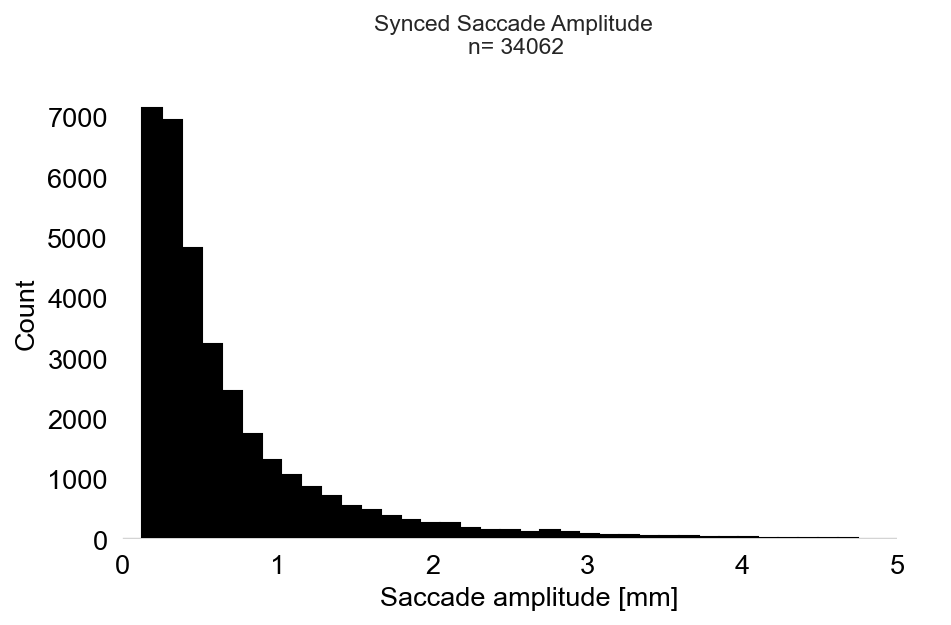

In [43]:
from scipy.stats import poisson
from matplotlib import rc
rc('pdf', fonttype=42)
import datetime
# make a histogram plot for all saccade magnitudes (L/R):
#all_magnitudes_mm = np.hstack([block.l_saccade_df['magnitude'].values * block.L_pix_size, block.r_saccade_df['magnitude'].values * block.R_pix_size])
all_magnitudes_mm = synced_saccade_collection['magnitude'].values
# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Plot the histogram
ax.hist(all_magnitudes_mm, bins=np.linspace(0, 5, 40), log=True, color='black', edgecolor='black')

# Set title and labels
title = (f'Synced Saccade Amplitude \n'
         f'n= {len(all_magnitudes_mm)}')
fig.suptitle(title, fontsize=11, y=1)

ax.set_xlabel('Saccade amplitude [mm]', fontsize=13)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=13)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
#ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')

# Set the x-axis to start precisely at 0
ax.set_xlim(left=0)
ax.tick_params(colors='black')

t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
plt.savefig(rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_multi_animal_Saccade_amplitude_distribution_synced.pdf', format='pdf')
plt.show()

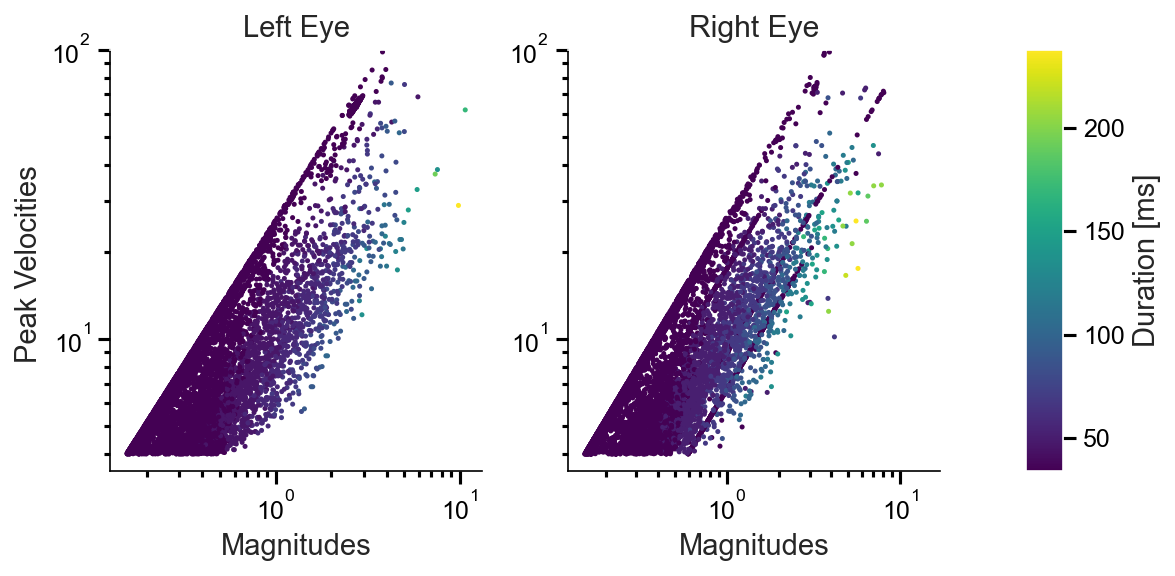

In [44]:
# This cell creates the saccade magnitude Vs velocity graphs + length information:
df = non_synced_saccade_collection
l_magnitudes = df.query('eye == "L"').magnitude.values
l_peak_velocities = np.array([np.nanmax(i) for i in df.query('eye == "L"').speed_profile])
l_mean_velocities = np.array([np.nanmean(i) for i in df.query('eye == "L"').speed_profile])
l_length = df.query('eye == "L"').length.values * 17 # convert to ms according to 60 fps
r_magnitudes = df.query('eye == "R"').magnitude.values
r_peak_velocities = np.array([np.nanmax(i) for i in df.query('eye == "R"').speed_profile])
r_mean_velocities = np.array([np.nanmean(i) for i in df.query('eye == "R"').speed_profile])
r_length = df.query('eye == "R"').length.values * 17

all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
all_mean_velocities = np.concatenate((l_mean_velocities, r_mean_velocities))

x_min, x_max = all_magnitudes.min(), all_magnitudes.max()
y_min, y_max = all_peak_velocities.min(), all_peak_velocities.max()

# Find global min and max for mean velocities
c_min, c_max = all_mean_velocities.min(), all_mean_velocities.max()

plt.rcParams.update({'font.size': 12}) 
fig, axs = plt.subplots(1,3, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1, 0.1]}, dpi=150)

# Left eye scatter plot
sc_left = axs[0].scatter(l_magnitudes, l_peak_velocities, s=2, c=l_length, cmap='viridis')
axs[0].set_xlabel('Magnitudes', fontsize=14)
axs[0].set_ylabel('Peak Velocities ', fontsize=14)
axs[0].set_title('Left Eye', fontsize=14)
axs[0].grid(False)
#axs[0].set_xlim([0, x_max])
#axs[0].set_ylim([0, y_max])
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylim(3.5,100)
# Right eye scatter plot
sc_right = axs[1].scatter(r_magnitudes, r_peak_velocities,s=2, c=r_length, cmap='viridis')
# cbar_right = plt.colorbar(sc_right, ax=axs[1])
# cbar_right.set_label('Mean Velocities', fontsize=16)
axs[1].set_xlabel('Magnitudes', fontsize=14)
#axs[1].set_ylabel('Peak Velocities', fontsize=16)
axs[1].set_title('Right Eye')
axs[1].grid(False)
#axs[1].set_xlim([0, x_max])
#axs[1].set_ylim([0, y_max])
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_ylim(3.5,100)
# Set subplot backgrounds to white
axs[0].set_facecolor('white')
axs[1].set_facecolor('white')

for ax in axs:
    #ax.spines['top'].set_visible(True)
    #ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    # Set spine color
    #ax.spines['top'].set_color('black')
    #ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.tick_params(axis='both', direction='out', which='major',length=6, width=1.5, colors='black', bottom=True, left=True)
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1.5,colors='black', bottom=True, left=True)
    
    
cbar = plt.colorbar(sc_right, cax=axs[2])
cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
cbar.set_label('Duration [ms]', fontsize=14)

# final touches
#fig.suptitle('Saccade Magnitude Vs Velocity', y=1.00, x=0.48, fontsize=16)
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#export_to = rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\{t}_saccade_magnitude_Vs_Velocity_with_Duration_log_non_synced.pdf'
#plt.savefig(export_to, format='pdf')
plt.show()

In [45]:
print(f'{block.animal_call},{block.block_num},{block.L_pix_size}')

PV_57,013,0.040185797553099374


In [46]:
for block in block_collection:
    print(f'{block.animal_call},{block.block_num},{block.L_pix_size}')

PV_57,001,0.040048621934616065
PV_57,002,0.03884654144995852
PV_57,004,0.05364488482516322
PV_57,005,0.04523554007282159
PV_57,008,0.039043553366470314
PV_57,009,0.03930809516442342
PV_57,010,0.04292770348867807
PV_57,011,0.04199428310994708
PV_57,012,0.04120218249464658
PV_57,013,0.040185797553099374


In [47]:
known_dist = 7.8
for block in block_collection:
    print(block)
    print(f'left calib = {known_dist / block.L_pix_size}')
    print(f'right calib = {known_dist / block.R_pix_size}')

PV_57, block 001, on pv_57_trial01_2024-11-21_15-32-31
left calib = 194.76325584272007
right calib = 136.69511315721218
PV_57, block 002, on pv_57_trial02_2024-11-21_15-55-01
left calib = 200.7900757406636
right calib = 136.81533359390113
PV_57, block 004, on pv_57_trial04_2024-11-21_16-33-37
left calib = 145.4006290706258
right calib = 70.03235348755577
PV_57, block 005, on pv_57_day2_01_2024-11-25_14-59-12
left calib = 172.43079197116506
right calib = 52.35168064031726
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18
left calib = 199.77689855192475
right calib = 190.76115905112923
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35
left calib = 198.43240857571612
right calib = 198.25156383835684
PV_57, block 010, on PV_57_hunter__2024-12-01_15-37-36
left calib = 181.70084505119647
right calib = 200.68083366699898
PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
left calib = 185.73956792114956
right calib = 202.329586546811
PV_57, block 012, on PV_57_hunter_2_2024-12-0